# Предсказание показаний состояния пациента

Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

# ЗАДАЧА - Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
%matplotlib inline

import math
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import Model
from keras.layers import *
from keras.regularizers import L2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.metrics import RootMeanSquaredError


2022-11-11 14:40:38.142464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])


# Check the data

Divide dataset to treatment and pynamic parameters

In [4]:
stat_fact_df = df.iloc[:,0:29]
stat_fact_df = stat_fact_df.sort_values(["case", "t_point"])
stat_fact_df.head()

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        3                             1                        1  ...   
GACAAnf 0                             1                        1  ...   

                 метилпреднизолон_stat_control  лоратадин_stat_control  \
case    t_point                                                          
GACAAcY 0                                    1                       0   
        1                                    1                       0   
        2                                    1                       0   
        3                                    1                       0   
GACAAnf 0                                    0                       0   

                 хлорохин_stat_control  натрия хлорид_stat_control  \
case    t_point                                                      
GACAAcY 0                            0                           0   
        1                            0                           0   
        2                            0                           0   
        3                            0                           0   
GACAAnf 0                            1                           0   

                 индапамид_stat_control  преднизолон_stat_control  \
case    t_point                                                     
GACAAcY 0                             0                         1   
        1                             0                         1   
        2                             0                         1   
        3                             0                         1   
GACAAnf 0                             0                         0   

                 аторвастатин_stat_control  дек

But initially check if treatment strategy has been changed? No. But found 22 records with no treatments at all.

In [5]:
non_typical_treatments = []
for i in stat_fact_df.index.levels[0]:
    means = stat_fact_df.loc[(i)].mean()
    if (set(means.unique()) != set([0,1])):
        non_typical_treatments.append([i, set(means.unique())])
non_typical_treatments

[['GACAJуЭ', {0.0}],
 ['GACAKАF', {0.0}],
 ['GACALрЫ', {0.0}],
 ['GACAT&H', {0.0}],
 ['GACA^МЮ', {0.0}],
 ['GACAb!2', {0.0}],
 ['GACAjц>', {0.0}],
 ['GACAjщ[', {0.0}],
 ['GACAjюc', {0.0}],
 ['GACAjяв', {0.0}],
 ["GACAk'5", {0.0}],
 ['GACAk){', {0.0}],
 ['GACAk+ц', {0.0}],
 ['GACAk.3', {0.0}],
 ['GACAm7g', {0.0}],
 ['GACAm?о', {0.0}],
 ['GACAmBц', {0.0}],
 ['GACAmCх', {0.0}],
 ['GACAmPф', {0.0}],
 ['GACAm^и', {0.0}],
 ['GACAmnW', {0.0}],
 ['GACAmЩП', {0.0}]]

*inof_df* static information about patient and treatment

In [6]:
info_df = pd.DataFrame()
info_df["age_stat_fact"] = df["age_stat_fact"]
info_df["outcome_tar"] = df["outcome_tar"]
info_df["long_observation_tar"] = df["long_observation_tar"]
info_df["admission_date"] = df["admission_date"]
info_df["process_stages"] = df["process_stages"]
periods = info_df.groupby("case").count()["age_stat_fact"]
info_df = info_df.groupby("case").first()
info_df["periods_stat_fact"] = periods
info_df

,age_stat_fact,outcome_tar,long_observation_tar,admission_date,process_stages,periods_stat_fact
case,,,,,,
GACAAcY,81,0,22,2021-01-29,2,4
GACAAnf,73,0,6,2020-06-06,1_2,2
GACABsT,59,0,14,2020-12-30,2,3
GACACKP,71,0,15,2021-01-26,2,3
GACADBj,37,0,20,2021-02-19,2,4
...,...,...,...,...,...,...
GACBAхz,25,0,14,2020-12-25,2,3
GACBAщн,37,0,15,2021-01-14,2,3
GACBB-В,70,0,1,2020-12-22,2,1


dinam_fact_df with dinamic parameters changed during observation. These columns are targets for our task

In [7]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

*dinam_control_df* procedures during observation. Unlike medicine, procedures has been changed during observation, so parameters pedends on time.

In [8]:
dinam_control_df = df.iloc[:,43:47]
dinam_control_df = dinam_control_df.sort_values(["case", "t_point"])

### Data preparation 

Make some transformations. Divide observations on train and test parts. We take some part as train period and next as test period. So we have X as (, WINDOW, PARAMS) and y (PARAMS)

In [9]:
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [10]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")

Count of patients: 1992


<AxesSubplot: >

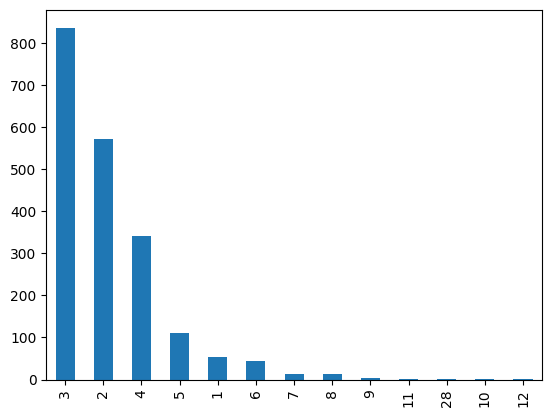

In [11]:
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

Impute NaN values using MICE methods with IterativeImputer on Linear regression as estimator 

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
dinam_fact_df = df.iloc[:, 29:42]
scal_model = MinMaxScaler().fit(dinam_fact_df)
pickle.dump(scal_model, open("models/standard_scaler.pkl", 'wb'))
df_scaled = scal_model.transform(dinam_fact_df)
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
imp = imp.fit(df_scaled)
pickle.dump(imp, open("models/iterative_imputer.pkl", 'wb'))
df_imputed = imp.transform(df_scaled)
dinam_fact_df = pd.DataFrame(data=df_imputed, columns = df.columns[29:42], index=df.index)
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.354167               0.012409   
        1                      0.270833               0.012896   
        2                      0.333333               0.013803   
        3                      0.312500               0.013733   
GACAAnf 0                      0.354510               0.007389   
...                                 ...                    ...   
GACBB;O 0                      0.395833               0.007459   
        1                      0.312500               0.010457   
GACXAAB 0                      0.312500               0.006692   
        1                      0.395833               0.010108   
        2                      0.333333               0.023005   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0              0.012004        0.496644        0.125000   
        1              0.011022        0.476510        0.093750   
        2              0.013833        0.481220        0.087500   
        3              0.011602        0.476510        0.087500   
GACAAnf 0              0.008791        0.369128        0.112500   
...                         ...             ...             ...   
GACBB;O 0              0.009523        0.362416        0.087500   
        1              0.108447        0.465736        0.081250   
GACXAAB 0              0.009282        0.466296        0.098837   
        1              0.026685        0.503356        0.075000   
        2              0.007229        0.490074        0.068750   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.118339   
        1                          0.093260   
        2                          0.080601   
        3                          0.087013   
GACAAnf 0                          0.059561   
...                                     ...   
GACBB;O 0                          0.009639   
        1                          0.028056   
GACXAAB 0                          0.033699   
        1                          0.007053   
        2                          0.071317   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       0.578125   
        1                                       0.531250   
        2                                       0.562500   
        3                                       0.593750   
GACAAnf 0                                       0.335938   
...                                                  ...   
GACBB;O 0                                       0.250000   
        1                                       0.265625   
GACXAAB 0                                       0.531250   
        1                                       0.546875   
        2                                       0.484375   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                          0.101604               0.497343   
        1                          0.165775               0.310308   
        2                          0.197861               0.229543   
        3                          0.101604               0.240170   
GACAAnf 0                          0.209626               0.240170   
...                                     ...                    ...   
GACBB;O 0                          0.137968               0.334750   
        1                          0.219251               0.421892   
GACXAAB 0                          0.208556               0.183847   
        1                          0.283422               0.121148   
        2                          0.294118          

Norm data by Standart Scaler and divide and train test parts

In [13]:
#module divides on X [[1, 2, 3, 4]] and y [5]
WINDOW = 3
PARAMS_LENGTH = 13

def df_to_X_y(df, window = 3):
    X, y = [], []
    st = df.groupby("case").size()
    st_idx = st[st==4].index
    for i in st_idx:
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy())
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = df_to_X_y(dinam_fact_df, WINDOW)
X

array([[[0.35416667, 0.0124085 , 0.01200357, ..., 0.4       ,
         0.03652344, 0.33887043],
        [0.27083333, 0.01289648, 0.01102187, ..., 0.4       ,
         0.05312501, 0.29900332],
        [0.33333333, 0.01380272, 0.01383311, ..., 1.        ,
         0.04719588, 0.32225914]],

       [[0.33333333, 0.00655281, 0.10013387, ..., 0.6       ,
         0.13850448, 0.2358804 ],
        [0.29166667, 0.01603346, 0.01026328, ..., 1.        ,
         0.04624722, 0.25913621],
        [0.29166667, 0.00864413, 0.00986167, ..., 1.        ,
         0.05952847, 0.27906977]],

       [[0.29166667, 0.0064831 , 0.00441767, ..., 0.6       ,
         0.05644532, 0.31229236],
        [0.29166667, 0.0078076 , 0.01164659, ..., 1.        ,
         0.04411273, 0.3255814 ],
        [0.375     , 0.00850471, 0.00691656, ..., 1.        ,
         0.03225447, 0.35880399]],

       ...,

       [[0.33333333, 0.00348554, 0.00858099, ..., 0.4       ,
         0.04414356, 0.37209302],
        [0.375     , 

Divide on test and train splits and delete last element to divide samples on batches

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/11)
X_train, y_train = X_train[:-1], y_train[:-1]
X_test, y_test = X_test[:-1], y_test[:-1]
print(X_train.shape)
print(y_test.shape)

(309, 3, 13)
(30, 13)


### Training

In [15]:
#function with results 
def show_results(X_test, y_test, model, history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.legend(["train loss", "validation loss", "validation root_mean_squared_error"])
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    r2_stat = r2_score(y_pred, y_test, multioutput="raw_values")
    predicted_values = scal_model.inverse_transform(y_pred)
    real_values = scal_model.inverse_transform(y_test)
    last_values = []
    last_values.extend(scal_model.inverse_transform(X_test[0]))
    stat=[]
    stat.extend(last_values)
    stat.append(real_values[0])
    stat.append(predicted_values[0])
    stat.append(r2_stat)
    df = pd.DataFrame(stat, index=[*["prev"]*len(last_values), "real", "predicted", "R2"], columns=dinam_fact_df.columns)
    print("Parameters on test datasets: \n")
    display(df)
    print(list(zip(model.metrics_names, model.evaluate(X_test, y_test, batch_size=BATCH_SIZE))))
    print(r2_score(y_pred, y_test))
    

### One layer RNN size 13

1. Simple RNN with state units 13 and batch size 48

In [71]:
BATCH_SIZE=1

model = Sequential(name="RNN13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(SimpleRNN(PARAMS_LENGTH, activation="relu", return_sequences=False))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_simple_rnn_13.summary()

Model: "RNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (1, 13)                   351       
                                                                 
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________


Lets show learning history for the model. We see intersection on 15 epochs - model becomes overfit.

In [72]:
history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, validation_data=(X_test, y_test), batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_simple_rnn_13.save("models/minmax_scaler/RNN13")

INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13/assets


INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13/assets


Lets show on table what we have predicted:

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.677951,0.323390,155.767012,88.000000,24.000000,11.814538,8.420496,0.097799,35.911682,2.0,3.000000,499.532305,18.309219
prev,36.581962,0.431680,163.568703,76.558460,24.532486,12.670156,8.435863,0.112124,35.463301,2.0,5.000000,522.095871,18.600803
prev,36.692663,-0.068146,163.030032,76.705552,26.315842,11.565431,8.508456,0.087217,34.542513,2.0,2.000000,523.214781,18.048290
real,36.581962,0.431680,163.568703,76.558460,24.532486,12.670156,8.435863,0.112124,35.463301,2.0,5.000000,522.095871,18.600803
predicted,36.608101,0.150000,321.986969,80.555779,4.000000,21.865112,7.641882,0.005000,40.052574,0.0,4.642076,91.000000,3.800000
R2,-3.177162,0.000000,0.545439,-7.029759,-0.990476,-0.980542,0.449391,0.000000,0.077619,0.0,-24.515192,-153.908181,0.000000


30/30 [==============================] - 0s 958us/step - loss: 0.0250 - root_mean_squared_error: 0.1582
[('loss', 0.025015762075781822), ('root_mean_squared_error', 0.15816371142864227)]
-14.579143367377558


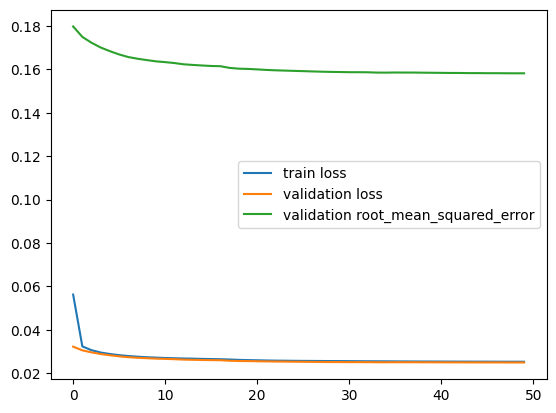

In [73]:
show_results(X_test, y_test, model_simple_rnn_13, history)

### LSTM with 13 units and batch 12

In [19]:
BATCH_SIZE=12

model = Sequential(name="LSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=12))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13 = model
model_lstm_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13.summary()

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (12, 13)                  1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_train.shape

(309, 3, 13)

In [67]:
valsp = 2
bs = 12
x = 300
print(x*(valsp*bs/x), (x-x*(valsp*bs/x))/bs)

24.0 23.0


In [66]:
cut = 300
BATCH_SIZE = 12
history = model_lstm_13.fit(X_train[:cut], y_train[:cut],
 epochs=100, validation_split=2*BATCH_SIZE/300, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13")


InvalidArgumentError: Graph execution error:

Specified a list with shape [12,13] from a tensor with shape [7,13]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[LSTM13/lstm/PartitionedCall]] [Op:__inference_test_function_82099]

KeyError: 'val_loss'

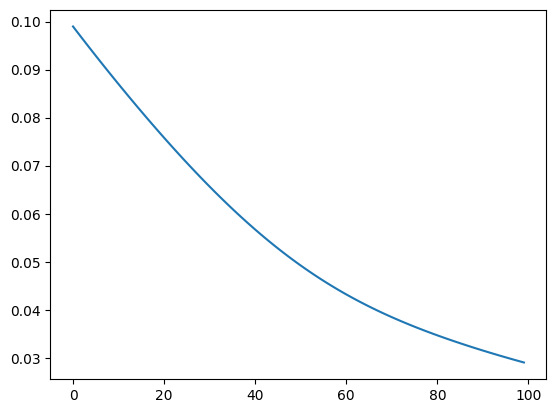

In [26]:
show_results(X_test, y_test, model_lstm_13, history)

### LSTM13 with batch 12

In [574]:
BATCH_SIZE=12

model = Sequential(name="LSTM13Batch12")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13_b12.summary()

Model: "LSTM13Batch12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_101 (LSTM)             (12, 13)                  1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [576]:
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=100, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13Batch12")

INFO:tensorflow:Assets written to: LSTM13Batch12\assets


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,7.899564,-0.095485,0.534416,-4.892760,0.358628,-0.909614,0.735147,-1.132532,0.806973,-0.250274,-0.407971,3.155857,-0.913153
prev,-0.067312,0.080203,0.255043,1.252381,0.135757,0.331474,0.481812,2.411029,-0.115322,-0.250274,-0.407971,0.850616,-1.195754
prev,-1.153704,0.037353,-0.395417,0.296470,-0.309985,-0.331573,1.051816,0.934545,-0.996442,-0.250274,0.866397,-0.537059,-0.545772
real,-0.067312,0.005214,-0.313581,0.022572,-0.755727,0.076680,1.051816,0.048655,-1.062320,-0.250274,0.866397,1.020536,-0.715332
predicted,-0.231923,0.004923,-0.159646,-0.083593,-0.544147,0.065932,0.629844,-0.011999,-0.369093,-0.240530,0.696363,-0.318631,-0.539232
R2,-3.860358,-32.158491,0.060516,-23.471114,-3.957132,-1.759859,0.002864,-1.684707,-3.324791,-4.927485,-4.392299,-0.370010,0.256925


4/4 [==============================] - 0s 2ms/step - loss: 0.6288 - root_mean_squared_error: 0.7930
[('loss', 0.6288164258003235), ('root_mean_squared_error', 0.7929794788360596)]
-6.12199545225948


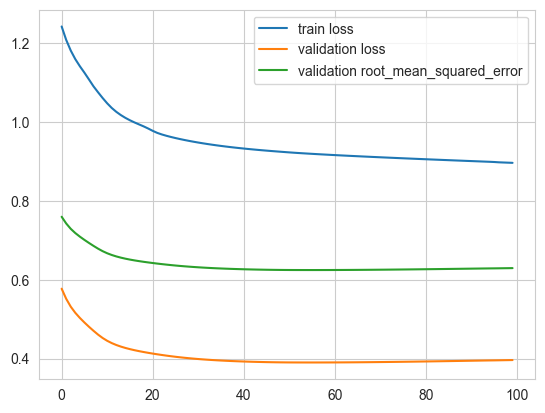

In [577]:
show_results(X_test, y_test, model_lstm_13_b12, history)

### LSTM64 Encoder + LSTM 13 Decoder 

In [506]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_64 = model
model_lstm_64.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_64.summary()

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (12, 3, 64)               19968     
                                                                 
 lstm_77 (LSTM)              (12, 13)                  4056      
                                                                 
Total params: 24,024
Trainable params: 24,024
Non-trainable params: 0
_________________________________________________________________


In [507]:
history = model_lstm_64.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xLSTM13")

INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,7.899564,-0.095485,0.534416,-4.892760,0.358628,-0.909614,0.735147,-1.132532,0.806973,-0.250274,-0.407971,3.155857,-0.913153
prev,-0.067312,0.080203,0.255043,1.252381,0.135757,0.331474,0.481812,2.411029,-0.115322,-0.250274,-0.407971,0.850616,-1.195754
prev,-1.153704,0.037353,-0.395417,0.296470,-0.309985,-0.331573,1.051816,0.934545,-0.996442,-0.250274,0.866397,-0.537059,-0.545772
real,-0.067312,0.005214,-0.313581,0.022572,-0.755727,0.076680,1.051816,0.048655,-1.062320,-0.250274,0.866397,1.020536,-0.715332
predicted,-0.513630,0.317439,-0.215176,-0.546215,-0.494306,-0.433444,0.664305,0.063597,-0.603813,-0.207475,0.789202,-0.427465,-0.843397
R2,-4.734574,-41.831585,0.008636,-13.494795,-3.802224,-0.666501,0.094172,-1.363016,-2.423627,-4.890182,-9.478247,-0.315871,0.305899


4/4 [==============================] - 0s 4ms/step - loss: 0.6145 - root_mean_squared_error: 0.7839
[('loss', 0.6144729852676392), ('root_mean_squared_error', 0.783883273601532)]
-6.353224192237743


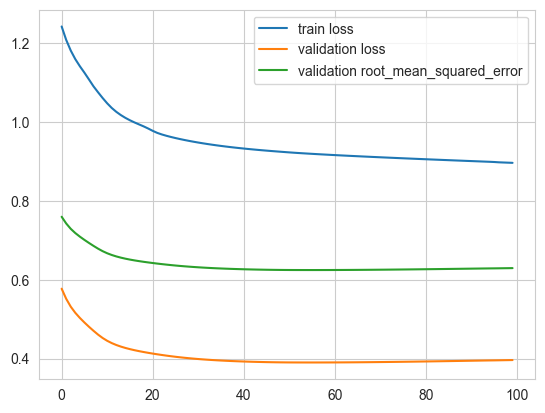

In [578]:
show_results(X_test, y_test, model_lstm_64, history)

## LSTM64+Dense13

In [517]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xDense13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_dense = model
model_lstm_dense.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_dense.summary()

Model: "LSTM64xDense13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (12, 64)                  19968     
                                                                 
 dense_133 (Dense)           (12, 13)                  845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


In [518]:
history = model_lstm_dense.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xDense13")

INFO:tensorflow:Assets written to: LSTM64xDense13\assets


INFO:tensorflow:Assets written to: LSTM64xDense13\assets


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,7.899564,-0.095485,0.534416,-4.892760,0.358628,-0.909614,0.735147,-1.132532,0.806973,-0.250274,-0.407971,3.155857,-0.913153
prev,-0.067312,0.080203,0.255043,1.252381,0.135757,0.331474,0.481812,2.411029,-0.115322,-0.250274,-0.407971,0.850616,-1.195754
prev,-1.153704,0.037353,-0.395417,0.296470,-0.309985,-0.331573,1.051816,0.934545,-0.996442,-0.250274,0.866397,-0.537059,-0.545772
real,-0.067312,0.005214,-0.313581,0.022572,-0.755727,0.076680,1.051816,0.048655,-1.062320,-0.250274,0.866397,1.020536,-0.715332
predicted,-0.153214,-0.000593,0.000622,-0.098923,-0.455088,-0.559219,0.697341,0.266867,-0.102818,-0.339013,0.908800,-0.308228,-0.871634
R2,-1.584225,0.964471,0.494715,-11.536973,-0.717569,0.156349,0.320791,-0.430612,0.210505,0.981267,-5.833030,0.320553,0.148417


4/4 [==============================] - 0s 3ms/step - loss: 0.5615 - root_mean_squared_error: 0.7493
[('loss', 0.5615184903144836), ('root_mean_squared_error', 0.7493454217910767)]
-1.269641611532322


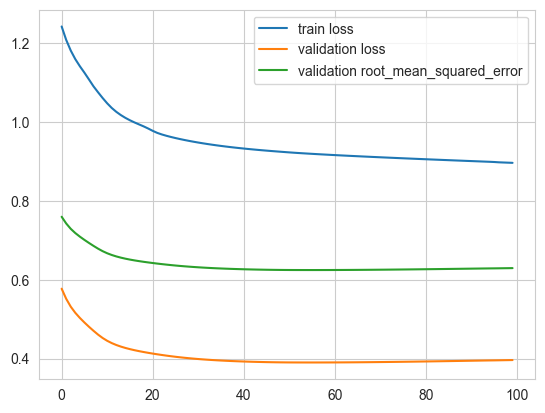

In [579]:
show_results(X_test, y_test, model_lstm_dense, history)

As we used Standard scaling, better to use tanh as activation

In [580]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xDense13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="tanh"))
model_lstm_dense = model
model_lstm_dense.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_dense.summary()

Model: "LSTM64xDense13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (12, 64)                  19968     
                                                                 
 dense_192 (Dense)           (12, 13)                  845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM64xDense13\assets


INFO:tensorflow:Assets written to: LSTM64xDense13\assets


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,7.899564,-0.095485,0.534416,-4.892760,0.358628,-0.909614,0.735147,-1.132532,0.806973,-0.250274,-0.407971,3.155857,-0.913153
prev,-0.067312,0.080203,0.255043,1.252381,0.135757,0.331474,0.481812,2.411029,-0.115322,-0.250274,-0.407971,0.850616,-1.195754
prev,-1.153704,0.037353,-0.395417,0.296470,-0.309985,-0.331573,1.051816,0.934545,-0.996442,-0.250274,0.866397,-0.537059,-0.545772
real,-0.067312,0.005214,-0.313581,0.022572,-0.755727,0.076680,1.051816,0.048655,-1.062320,-0.250274,0.866397,1.020536,-0.715332
predicted,-0.028164,0.025682,-0.021395,0.154488,-0.442718,-0.230049,0.786587,0.028178,-0.502800,-0.142082,0.599560,-0.556007,-0.820332
R2,-3.741396,-39.852638,0.078364,-17.054125,-3.582279,-0.767560,0.089735,-0.901501,-2.094626,-4.970409,-7.929517,-0.176319,0.245797


4/4 [==============================] - 0s 2ms/step - loss: 0.6091 - root_mean_squared_error: 0.7805
[('loss', 0.6091167330741882), ('root_mean_squared_error', 0.7804593443870544)]
-6.204344096171223


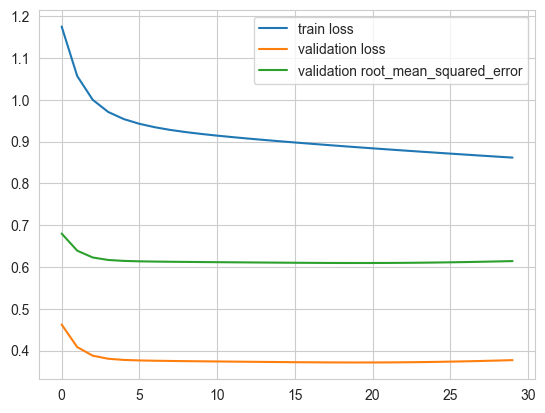

In [581]:
history = model_lstm_dense.fit(X_train, y_train,
                               epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
                               shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xDense13")
show_results(X_test, y_test, model_lstm_dense, history)

### Lets add static parameters as additional inputs to fully connected layer

Lets define new function for splitting

In [520]:
def split_features_targets(df, dinam_fact_df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        sample_data = np.array([])
        for j in range(window):
            sample_data = np.append(sample_data, dinam_fact_df.loc[(i, j)].to_numpy()) # facts
            sample_data = np.append(sample_data, df.loc[(i, j)].iloc[43:47].to_numpy()) #controls
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[:29].to_numpy()) #medicines
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[42]) #age
        X.append(sample_data)
        y.append(dinam_fact_df.loc[(i, window)].to_numpy())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/11)
    X, T, y = [], [], []
    X_t, T_t, y_t = [], [], []
    for i in range(len(X_train)):
        X.append(X_train[i][:window*17].reshape(3, 17))
        T.append(X_train[i][window*17:])
        y = y_train.copy()
    for i in range(len(X_test)):
        X_t.append(X_test[i][:window*17].reshape(3, 17))
        T_t.append(X_test[i][window*17:])
        y_t = y_test.copy()

    return (np.array(X).astype(np.float32), np.array(T).astype(np.float32), np.array(y)), (np.array(X_t).astype(np.float32), np.array(T_t).astype(np.float32), np.array(y_t))

In [521]:
(X, T, y), (X_t, T_t, y_t) = split_features_targets(df, dinam_fact_df)

Now we have such dinam_facts and dinam_controls frame:

In [426]:
X[7]

array([[ 5.7267795 , -0.11048325,  0.32418048, -0.04492673,  0.5814994 ,
        -0.82460827,  0.7351473 ,  0.04865517, -0.5517645 , -0.25027362,
        -1.6823391 , -0.31616366, -0.96967304,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.4294428 , -0.12762363,  0.7855698 , -0.9325581 ,  0.13575734,
        -0.03283146,  0.3551451 ,  1.6235713 , -0.7823381 , -0.25027362,
         0.22921328,  1.5925978 , -1.1957537 ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.06731208, -0.20261279, -0.40247238, -0.59116143, -0.30998468,
         0.19546469,  0.5451462 ,  2.2141647 , -1.3093634 , -0.25027362,
         0.8663974 ,  0.13129082, -1.1957537 ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

And frame with information about medicines and age:

In [427]:
T[7]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., 61.], dtype=float32)

In [522]:
T = T[:-1]
X = X[:-1]
y = y[:-1]
T_t = T_t[:-1]
X_t = X_t[:-1]
y_t = y_t[:-1]
print("T: ", T.shape)
print("X: ", X.shape)
print("y: ", y.shape)
print("T: ", T_t.shape)
print("X: ", X_t.shape)
print("y: ", y_t.shape)

T:  (480, 30)
X:  (480, 3, 17)
y:  (480, 13)
T:  (48, 30)
X:  (48, 3, 17)
y:  (48, 13)


In [582]:
def show_results_multimodal(X_test, T_test, y_test, model, history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.legend(["train loss", "validation loss", "validation root_mean_squared_error"])
    y_pred = model.predict([T_test, X_test], batch_size=BATCH_SIZE, verbose=0)
    r2_stat = r2_score(y_pred, y_test, multioutput="raw_values")
    r2_stat = np.array(r2_stat).reshape(1, 13)
    df = pd.DataFrame(r2_stat, index=["R2"], columns=dinam_fact_df.columns)
    print("Parameters on test datasets: \n")
    display(df)
    print(list(zip(model.metrics_names, model.evaluate([T_test, X_test], y_test, batch_size=BATCH_SIZE))))
    print(r2_score(y_pred, y_test))

In this model we pass static data first to Dense layer, and dinamic timesteps to LSTM. Combined results are processed by Dense layer

In [559]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='tanh')(lstm_layer)
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_161 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_99 (LSTM)                 (12, 17)             2380        ['input_161[0][0]']              
                                                                                                  
 input_160 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 dense_187 (Dense)              (12, 13)             234         ['lstm_99[0][0]']                
                                                                                           

INFO:tensorflow:Assets written to: Multimodal_DenseLSTM\assets


INFO:tensorflow:Assets written to: Multimodal_DenseLSTM\assets


In [560]:
history = model_multi.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_data=([T_t, X_t], y_t), epochs=80)
model_multi.save("Multimodal_DenseLSTM")

Epoch 1/80
40/40 [==============================] - 3s 21ms/step - loss: 1.1494 - root_mean_squared_error: 1.0721 - val_loss: 0.5265 - val_root_mean_squared_error: 0.7256
Epoch 2/80
40/40 [==============================] - 0s 8ms/step - loss: 1.0840 - root_mean_squared_error: 1.0412 - val_loss: 0.4822 - val_root_mean_squared_error: 0.6944
Epoch 3/80
40/40 [==============================] - 0s 6ms/step - loss: 1.0371 - root_mean_squared_error: 1.0184 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720
Epoch 4/80
40/40 [==============================] - 0s 8ms/step - loss: 1.0038 - root_mean_squared_error: 1.0019 - val_loss: 0.4310 - val_root_mean_squared_error: 0.6565
Epoch 5/80
40/40 [==============================] - 0s 7ms/step - loss: 0.9801 - root_mean_squared_error: 0.9900 - val_loss: 0.4167 - val_root_mean_squared_error: 0.6456
Epoch 6/80
40/40 [==============================] - 0s 5ms/step - loss: 0.9617 - root_mean_squared_error: 0.9807 - val_loss: 0.4068 - val_root_mean_s

INFO:tensorflow:Assets written to: Multimodal_DenseLSTM\assets


INFO:tensorflow:Assets written to: Multimodal_DenseLSTM\assets


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-6.535211,-0.038425,0.246508,-11.381865,-0.421314,-0.469539,-0.083432,-1.953321,-0.740843,-2.192207,-5.519806,-1.609487,0.275814


4/4 [==============================] - 0s 2ms/step - loss: 0.3875 - root_mean_squared_error: 0.6225
[('loss', 0.38748931884765625), ('root_mean_squared_error', 0.6224863529205322)]
-2.3402405098952297


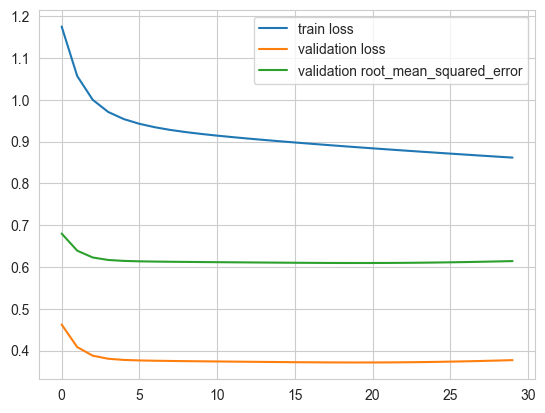

In [583]:
show_results_multimodal(X_t, T_t, y_t, model_multi, history)

As we see here, model is fitted, with RMSE 0.62, but R2 scores are negative

Here we save all states from LSTM cells, concatenate them and give to last dense layers as params

In [553]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(16, return_state=True)(input_dinamic)
flat_lst_layer = concatenate(lstm_layer)
result_layer = Dense(32, activation='relu')(concatenate([flat_lst_layer, dense_layer]))
result_layer = Dense(13, activation='tanh')(result_layer)
model_multi_s2 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s2.summary()
model_multi_s2.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_153 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_95 (LSTM)                 [(12, 32),           6400        ['input_153[0][0]']              
                                 (12, 32),                                                        
                                 (12, 32)]                                                        
                                                                                                  
 input_152 (InputLayer)         [(12, 30)]           0           []                               
                                                                                           

Epoch 1/80
35/35 [==============================] - 3s 24ms/step - loss: 1.7418 - root_mean_squared_error: 1.3198 - val_loss: 1.5128 - val_root_mean_squared_error: 1.2300
Epoch 2/80
35/35 [==============================] - 0s 6ms/step - loss: 1.2952 - root_mean_squared_error: 1.1381 - val_loss: 1.2015 - val_root_mean_squared_error: 1.0961
Epoch 3/80
35/35 [==============================] - 0s 8ms/step - loss: 1.1214 - root_mean_squared_error: 1.0589 - val_loss: 1.0634 - val_root_mean_squared_error: 1.0312
Epoch 4/80
35/35 [==============================] - 0s 7ms/step - loss: 0.9722 - root_mean_squared_error: 0.9860 - val_loss: 0.9631 - val_root_mean_squared_error: 0.9814
Epoch 5/80
35/35 [==============================] - 0s 5ms/step - loss: 0.9356 - root_mean_squared_error: 0.9672 - val_loss: 0.9666 - val_root_mean_squared_error: 0.9832
Epoch 6/80
35/35 [==============================] - 0s 5ms/step - loss: 0.9292 - root_mean_squared_error: 0.9640 - val_loss: 0.9557 - val_root_mean_s

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-3.744282,0.004969,0.072795,-4.63449,0.100809,-1.11893,-0.080378,-0.389847,-0.710452,-2.223323,-1.121214,-0.901408,0.259923


4/4 [==============================] - 0s 3ms/step - loss: 0.4272 - root_mean_squared_error: 0.6536
[('loss', 0.42718935012817383), ('root_mean_squared_error', 0.6535972356796265)]


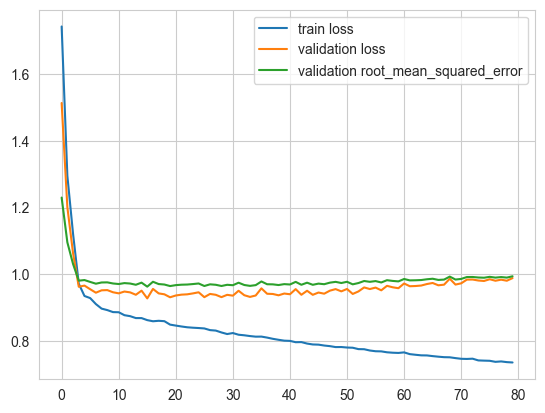

In [554]:
history = model_multi_s2.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-3.744282,0.004969,0.072795,-4.63449,0.100809,-1.11893,-0.080378,-0.389847,-0.710452,-2.223323,-1.121214,-0.901408,0.259923


4/4 [==============================] - 0s 2ms/step - loss: 0.4272 - root_mean_squared_error: 0.6536
[('loss', 0.42718935012817383), ('root_mean_squared_error', 0.6535972356796265)]
-1.1142943949879738


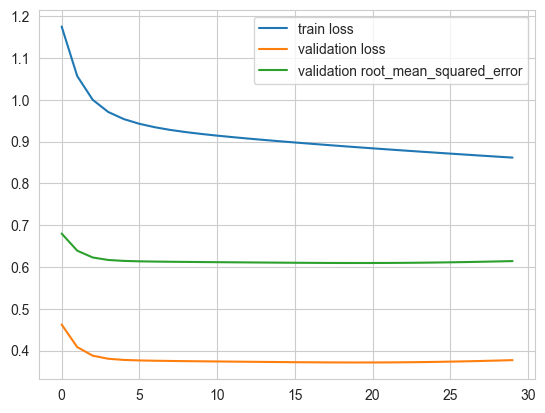

In [584]:
show_results_multimodal(X_t, T_t, y_t, model_multi_s2, history)

Lets use linear activation to compare results

In [549]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(32, activation='relu')(input_static)
dense_layer = Dense(12, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(32)(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s3 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s3.summary()
model_multi_s3.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_149 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 input_148 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 lstm_93 (LSTM)                 (12, 17)             2380        ['input_149[0][0]']              
                                                                                                  
 dense_171 (Dense)              (12, 12)             372         ['input_148[0][0]']              
                                                                                           

Epoch 1/100
35/35 [==============================] - 3s 16ms/step - loss: 37.6398 - root_mean_squared_error: 6.1351 - val_loss: 2.9339 - val_root_mean_squared_error: 1.7129
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 1.5276 - root_mean_squared_error: 1.2360 - val_loss: 1.3489 - val_root_mean_squared_error: 1.1614
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.1798 - root_mean_squared_error: 1.0862 - val_loss: 1.1890 - val_root_mean_squared_error: 1.0904
Epoch 4/100
35/35 [==============================] - 0s 6ms/step - loss: 1.1394 - root_mean_squared_error: 1.0674 - val_loss: 1.1589 - val_root_mean_squared_error: 1.0765
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 1.1093 - root_mean_squared_error: 1.0532 - val_loss: 1.1204 - val_root_mean_squared_error: 1.0585
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 1.0797 - root_mean_squared_error: 1.0391 - val_loss: 1.1111 - val_root

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.767069,-0.100873,0.416566,-7.912596,0.154873,-0.092809,0.409737,-1.996667,-0.992398,0.88557,-6.84056,-0.340282,0.484316


4/4 [==============================] - 0s 6ms/step - loss: 0.5188 - root_mean_squared_error: 0.7203
[('loss', 0.518792450428009), ('root_mean_squared_error', 0.7202724814414978)]


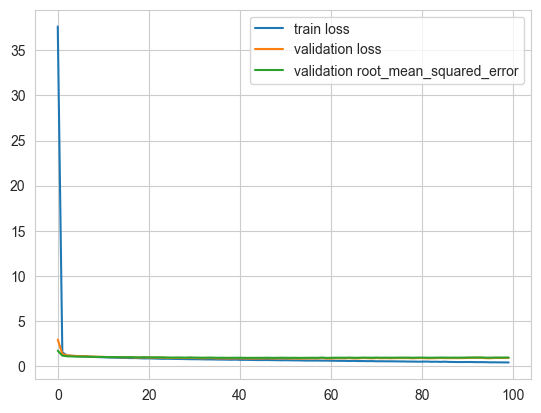

In [550]:
history = model_multi_s3.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=100)

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.767069,-0.100873,0.416566,-7.912596,0.154873,-0.092809,0.409737,-1.996667,-0.992398,0.88557,-6.84056,-0.340282,0.484316


4/4 [==============================] - 0s 2ms/step - loss: 0.5188 - root_mean_squared_error: 0.7203
[('loss', 0.518792450428009), ('root_mean_squared_error', 0.7202724814414978)]
-1.6686300805545702


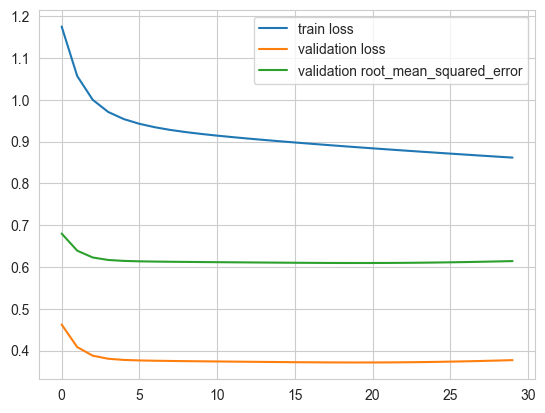

In [585]:
show_results_multimodal(X_t, T_t, y_t, model_multi_s3, history)

With linear activation, model seems to be more adequate, as more r2 scores are positive.

Here we add additional layerto information data

In [561]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(30, activation='relu')(input_static)
dense_layer = Dense(12, activation='relu')(input_static)
lstm_layer = LSTM(16, return_state=False)(input_dinamic)
result_layer = Dense(32)(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s4 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s4.summary()
model_multi_s4.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_163 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 input_162 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 lstm_100 (LSTM)                (12, 16)             2176        ['input_163[0][0]']              
                                                                                                  
 dense_189 (Dense)              (12, 12)             372         ['input_162[0][0]']              
                                                                                           

Epoch 1/40
35/35 [==============================] - 3s 23ms/step - loss: 13.4925 - root_mean_squared_error: 3.6732 - val_loss: 1.8562 - val_root_mean_squared_error: 1.3624
Epoch 2/40
35/35 [==============================] - 0s 9ms/step - loss: 1.3076 - root_mean_squared_error: 1.1435 - val_loss: 1.2495 - val_root_mean_squared_error: 1.1178
Epoch 3/40
35/35 [==============================] - 0s 7ms/step - loss: 1.1512 - root_mean_squared_error: 1.0729 - val_loss: 1.1630 - val_root_mean_squared_error: 1.0784
Epoch 4/40
35/35 [==============================] - 0s 7ms/step - loss: 1.1198 - root_mean_squared_error: 1.0582 - val_loss: 1.1587 - val_root_mean_squared_error: 1.0764
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 1.0891 - root_mean_squared_error: 1.0436 - val_loss: 1.0998 - val_root_mean_squared_error: 1.0487
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 1.0525 - root_mean_squared_error: 1.0259 - val_loss: 1.0671 - val_root_mean_

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-9.97125,-0.012811,0.223352,-13.352751,-1.489457,-0.262107,0.330958,-3.347081,-0.81529,0.812381,-9.289847,-1.842228,0.528473


4/4 [==============================] - 0s 6ms/step - loss: 0.4660 - root_mean_squared_error: 0.6826
[('loss', 0.4660094976425171), ('root_mean_squared_error', 0.6826488375663757)]


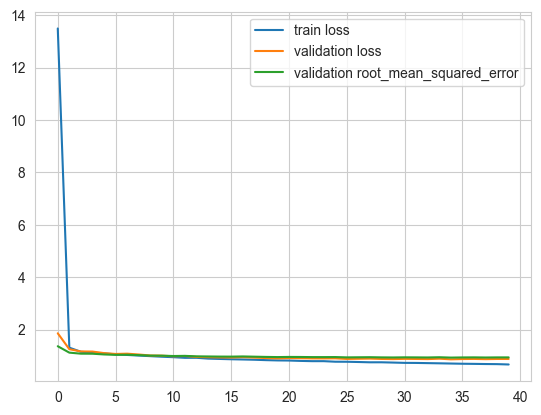

In [562]:
history = model_multi_s4.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=40)
show_results_multimodal(X_t, T_t, y_t, model_multi_s4, history)

In result we do not see some improvements with this method

And now we can multiply DENSE output and put it to LSTM cells, so each timestep will know information about treatment.
...TBD